In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize

from functools import partial
import itertools
import re

import matplotlib.gridspec as gridspec
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd
import seaborn as sns

print(__doc__)
import pandas as pd
from patsy import dmatrices
import scipy as sc
import scipy.optimize as opt
import statsmodels.api as sm

import sklearn as sk


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import TransformerMixin
from sklearn.pipeline import BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import column_or_1d
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union


from sklearn.datasets import samples_generator
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction import DictVectorizer

import sklearn.feature_extraction as fe

import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

import sklearn.linear_model as lm
import sklearn.grid_search as gs
from sklearn.svm import SVC
from sklearn.decomposition import PCA


import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cv
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn_pandas import DataFrameMapper, cross_val_score

import matplotlib.pyplot as plt
import patsy
from statsmodels.sandbox import cox

from patsylearn import *

import joblib as jb


from datasu.auc import *
from datasu.dicts import *
from datasu.files import *
from datasu.pandas import *
from datasu.persist import *


import pandas as pd

Couldn't import dot_parser, loading of dot files will not be possible.
Automatically created module for IPython interactive environment


/home/ds/.pyenv/versions/anaconda2-2.4.1/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## UTILS

## LOAD DATA

In [2]:
main_folder = '~/dev/data/Kagle-ValuesShoppers/'
df_coupons = pd.read_csv(main_folder+'offers')[['offer','category','company','brand','offervalue','quantity']]
df_offers_ids = pd.read_csv(main_folder+'trainHistory').rename(columns={'id': 'customer_id'})
df_offers_ids_submission = pd.read_csv(main_folder+'testHistory').rename(columns={'id': 'customer_id'})
# df_trans_all = pd.read_csv(main_folder+'transactions_reduced_category').rename(columns={'id': 'customer_id'})

In [3]:
df_offers_all = pd.merge(df_offers_ids, df_coupons, on=['offer'])
df_offers_all = df_offers_all[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity','repeattrips','repeater']]

df_offers_all_submission = pd.merge(df_offers_ids_submission, df_coupons, on=['offer'])
df_offers_all_submission = df_offers_all_submission[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity']]

In [4]:
df_coupons.head()

,offer,category,company,brand,offervalue,quantity
0,1190530,9115,108500080,93904,5.00,1
1,1194044,9909,107127979,6732,1.00,1
2,1197502,3203,106414464,13474,0.75,1
3,1198271,5558,107120272,5072,1.50,1
4,1198272,5558,107120272,5072,1.50,1


In [5]:
df_coupons[df_coupons.offer==1213242]

,offer,category,company,brand,offervalue,quantity
26,1213242,5824,105190050,26456,2,1


In [6]:
df_offers_all.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


/home/ds/.pyenv/versions/anaconda2-2.4.1/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':
/home/ds/.pyenv/versions/anaconda2-2.4.1/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


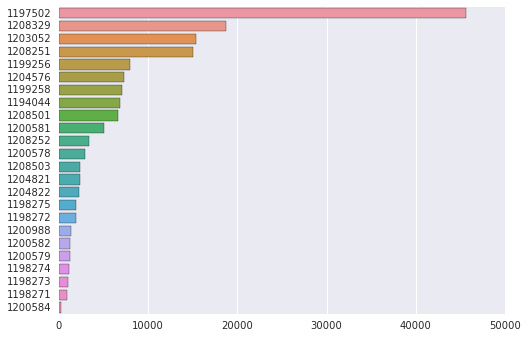

In [7]:
offer_counts = df_offers_all.groupby(by='offer').count().customer_id.order(ascending=False)
sns.barplot(y=offer_counts.index.values, x=offer_counts.values, orient='h')

In [8]:
df_offers_all.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


In [9]:
customer_counts = df_offers_all.groupby(by='customer_id').count().offer.order(ascending=False)
# sns.barplot(y=customer_counts.index.values, x=customer_counts.values, orient='h')

/home/ds/.pyenv/versions/anaconda2-2.4.1/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


## FILTER DATA

In [10]:
df_trans = df_trans_all#[0:3000000]

NameError: name 'df_trans_all' is not defined

In [11]:
df_offers_filtered = df_offers_all#[df_offers_all.offer==1197502]

In [12]:
len(df_trans.customer_id.unique()), len(df_trans.customer_id),  len(df_offers_filtered.customer_id.unique()),len(df_offers_filtered.customer_id), 

NameError: name 'df_trans' is not defined

### LOAD FEATURES FROM DISK

In [13]:
main_folder = '~/dev/data/Kagle-ValuesShoppers/'
load_variables(path=main_folder+'working_data');

['df_trans_grp_customer_brand.var', 'df_trans_grp_customer_category.var', 'df_trans_grp_customer_dept.var', 'df_offers__trans_aggs.var']
loaded df_trans_grp_customer_brand
loaded df_trans_grp_customer_category
loaded df_trans_grp_customer_dept
loaded df_offers__trans_aggs


### MERGE FEATURES TO ONE TABLE

In [14]:
print len(df_offers_all)
df_offers_all.head()

160057


,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


In [15]:
df_offers_all_merge4 = merge_data(df_offers_all, how='left',
                                  rights=[(df_trans_grp_customer_brand,['customer_id','brand']),
                                          (df_trans_grp_customer_category,['customer_id', 'category']),
#                                           (df_trans_grp_customer_dept,['customer_id'])
                                         ])

df_offers_all_merge4.fillna(0, inplace=True)
df_offers_all_merge4.head()

160057
160057
160057


,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,...,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,...,5.69,1,1,0,0,0,0,0,0,0
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,...,0.00,0,0,0,0,0,0,0,0,0
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,...,0.00,0,0,0,0,0,0,0,0,0
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,...,0.00,0,0,0,0,0,0,0,0,0
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,...,0.00,0,0,0,0,0,0,0,0,0


In [16]:
len(df_offers_all), len(df_offers_all_merge4), len(df_offers_all_merge4.columns)

(160057, 160057, 26)

In [17]:
df_offers_all_merge4.brand.unique()

array([  3718,  13474, 102504,   7668,  15889,    875,  13791,   5072,
         6926,  64486,  28840,   6732])

In [18]:
df_offers__trans_aggs = df_offers_all_merge4
persist_variables(['df_offers__trans_aggs']
                  ,path=main_folder+'working_data')

dumping df_offers__trans_aggs to ~/dev/data/Kagle-ValuesShoppers/working_data/df_offers__trans_aggs.var


### CLEAR MEMORY

In [19]:
# %reset_selective -f df_trans_all
# %reset_selective -f df_trans

## TRAIN MODEL

In [20]:
df_data_train = df_offers_all_merge4

In [21]:
df_data_train.columns

Index([u'customer_id', u'chain', u'offer', u'market', u'category', u'company',
       u'brand', u'offerdate', u'offervalue', u'quantity', u'repeattrips',
       u'repeater', u'agg_productsize_customer_id_brand_average',
       u'agg_productsize_customer_id_brand_total',
       u'agg_customer_id_customer_id_brand_count',
       u'agg_purchaseamount_customer_id_brand_average',
       u'agg_purchaseamount_customer_id_brand_total',
       u'agg_purchasequantity_customer_id_brand_average',
       u'agg_purchasequantity_customer_id_brand_total',
       u'agg_productsize_customer_id_category_total',
       u'agg_productsize_customer_id_category_average',
       u'agg_customer_id_customer_id_category_count',
       u'agg_purchaseamount_customer_id_category_total',
       u'agg_purchaseamount_customer_id_category_average',
       u'agg_purchasequantity_customer_id_category_total',
       u'agg_purchasequantity_customer_id_category_average'],
      dtype='object')

In [22]:
df_data_train.repeattrips.sum()

105051

In [23]:
categorical_cols = ['chain','market','category','company','brand']
agg_cols = filter(lambda c: re.match("agg_*",c), df_data_train.columns)
num_cols = ['offervalue','quantity']


In [24]:
df_X = df_data_train.filter(items=categorical_cols+agg_cols+num_cols) 
columns_to_type(df_X, categorical_cols, 'category')

df_Y = df_data_train[['repeater']]
Y = df_Y.repeater.map(lambda v: v=='t')
W = df_data_train.repeattrips.replace(to_replace=0, value=1).values

In [25]:
categorical_cols

['chain', 'market', 'category', 'company', 'brand']

In [26]:
df_X.columns

Index([u'chain', u'market', u'category', u'company', u'brand',
       u'agg_productsize_customer_id_brand_average',
       u'agg_productsize_customer_id_brand_total',
       u'agg_customer_id_customer_id_brand_count',
       u'agg_purchaseamount_customer_id_brand_average',
       u'agg_purchaseamount_customer_id_brand_total',
       u'agg_purchasequantity_customer_id_brand_average',
       u'agg_purchasequantity_customer_id_brand_total',
       u'agg_productsize_customer_id_category_total',
       u'agg_productsize_customer_id_category_average',
       u'agg_customer_id_customer_id_category_count',
       u'agg_purchaseamount_customer_id_category_total',
       u'agg_purchaseamount_customer_id_category_average',
       u'agg_purchasequantity_customer_id_category_total',
       u'agg_purchasequantity_customer_id_category_average', u'offervalue',
       u'quantity'],
      dtype='object')

In [27]:
print len(categorical_cols+agg_cols), len(df_X.columns)
print len(df_X),len(df_Y)

19 21
160057 160057


### BUILD PIPELINE

In [28]:
mapper = DataFrameMapper([
        (col, sk.preprocessing.LabelBinarizer()) for col in categorical_cols] 
      + [(agg_cols+num_cols, None)])

prepare_pipeline = make_pipeline(mapper,
                        PolynomialFeatures(degree=1, interaction_only=True),                         
                        preprocessing.StandardScaler()
                        ) 

In [29]:
fit_pipeline_LR1 = make_pipeline(prepare_pipeline,
                             lm.LogisticRegression(C=0.001, penalty='l1'))     
# class_weight=W_train

### SPLIT TRAIN-TEST

In [30]:
df_X_train, df_X_test, Y_train, Y_test, W_train, W_test = train_test_split(df_X, Y, W)
len(df_X_train),len(df_X_test)


(120042, 40015)

### FIT MODEL

In [31]:
fit_pipeline_LR1.fit(df_X_train, y=Y_train)
print 'score in-sample: ' + str(fit_pipeline_LR1.score(df_X_train, y=Y_train))

score in-sample: 0.745505739658


In [32]:
logreg = fit_pipeline_LR1.named_steps['logisticregression']
logreg.classes_
sum(logreg.coef_[0,:])

0.69976745852257505

In [33]:
len(logreg.coef_[0,:])


214

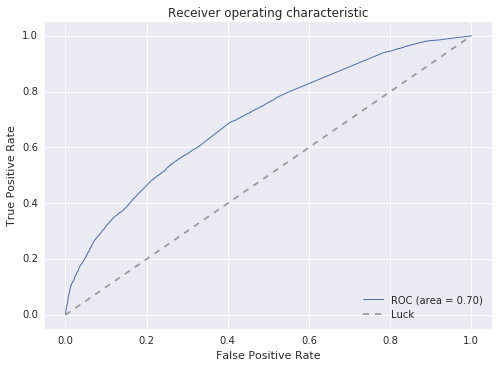

In [38]:
plot_auc(Y_test, fit_pipeline_LR1.decision_function(df_X_test))

In [36]:
fit_pipeline_LR1.decision_function(df_X_test)

array([-1.01555759, -1.30579792, -1.01555759, ..., -1.01555759,
       -0.79093189, -0.43163432])

### CROSSVALIDATION

In [ ]:
scores = cv.cross_val_score(fit_pipeline_LR1, df_X, Y,cv=5, scoring='accuracy')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# X_test = prepare_pipeline.transform(X_test)
# print 'Test accuracy: %0.2f' % fit_pipeline.score(X_test, Y_test


In [ ]:
run_crossval(df_X_train, Y_train, fit_pipeline_LR1)

## TEST ON KAGGLE

### FIT MODEL ON ALL DATA

In [ ]:
fit_pipeline_LR1.fit(df_X_train, y=Y_train)
print 'score in-sample: ' + str(fit_pipeline_LR1.score(df_X_train, y=Y_train))

### PREPARA DATA FOR PREDICTION

In [ ]:
df_offers_all_submission.head()

In [ ]:
df_offers_all_submission_merge4 = merge_data(df_offers_all_submission, how='left',
                                             rights=[(df_trans_grp_customer_brand,['customer_id','brand']),
                                                     (df_trans_grp_customer_category,['customer_id', 'category']),
#                                                      (df_trans_grp_customer_dept,['customer_id'])
                                                    ])
df_offers_all_submission_merge4.fillna(0, inplace=True)

In [ ]:
len(df_offers_all_submission_merge4), len(df_offers_all_submission.customer_id.unique())

In [ ]:
df_offers_all_submission_merge4[df_offers_all_submission_merge4.customer_id==12262064]

In [ ]:
df_X_submission = df_offers_all_submission_merge4.filter(items=categorical_cols+agg_cols+num_cols) 
columns_to_type(df_X_submission, categorical_cols, 'category')


In [ ]:
df_X_submission.columns

In [ ]:
probas_ = fit_pipeline_LR1.decision_function(df_X_submission).astype(float)

In [ ]:
len(probas_)
probas_

In [ ]:
sum(probas_),sum(probas_)

In [ ]:
df_submission = df_offers_all_submission.customer_id.to_frame(name='id')
df_submission['repeatProbability'] = probas_.tolist()
df_submission.head()

In [ ]:
df_submission.to_csv(path_or_buf=main_folder+'submission13_LR1', index=False)

## OTHER

In [ ]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html
    
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import numpy as np
from sklearn import linear_model

###############################################################################
# Generate sample data
n_samples_train, n_samples_test, n_features = 75, 150, 500
np.random.seed(0)
coef = np.random.randn(n_features)
coef[50:] = 0.0  # only the top 10 features are impacting the model
X = np.random.randn(n_samples_train + n_samples_test, n_features)
y = np.dot(X, coef)

# Split train and test data
X_train, X_test = X[:n_samples_train], X[n_samples_train:]
y_train, y_test = y[:n_samples_train], y[n_samples_train:]

###############################################################################
# Compute train and test errors
alphas = np.logspace(-5, 1, 60)
enet = linear_model.ElasticNet(l1_ratio=0.7)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

###############################################################################
# Plot results functions

import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)
plt.plot(coef, label='True coef')
plt.plot(coef_, label='Estimated coef')
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

In [ ]:
# http://scikit-learn.org/stable/auto_examples/feature_stacker.html
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

# PREPARE FILES